In [27]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

### 1. Bộ dữ liệu ARE Historical Data

In [69]:
# 2. Đọc file csv và gắng index với giá Close
df1 = pd.read_csv('ARE-Historical-Data.csv')
df1=df1.reset_index()['Price']

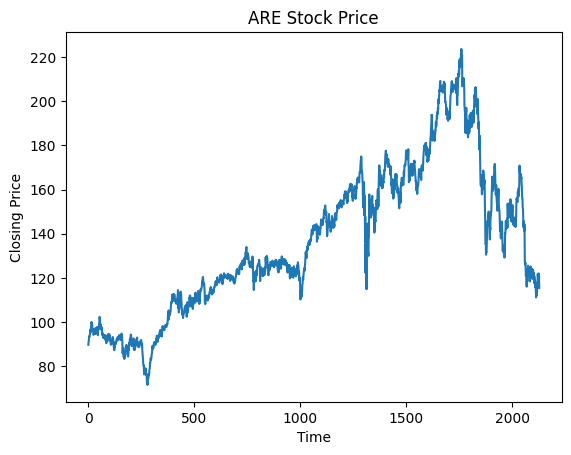

In [70]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df1)
plt.title('ARE Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

In [71]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [72]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [73]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [74]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [75]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [76]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [77]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 [==============================] - 6s 121ms/step - loss: 0.0360 - val_loss: 0.0328
Epoch 2/100
22/22 [==============================] - 2s 85ms/step - loss: 0.0032 - val_loss: 0.0052
Epoch 3/100
22/22 [==============================] - 2s 84ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 4/100
22/22 [==============================] - 2s 84ms/step - loss: 0.0011 - val_loss: 0.0051
Epoch 5/100
22/22 [==============================] - 2s 84ms/step - loss: 0.0010 - val_loss: 0.0044
Epoch 6/100
22/22 [==============================] - 2s 88ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 7/100
22/22 [==============================] - 2s 86ms/step - loss: 0.0010 - val_loss: 0.0044
Epoch 8/100
22/22 [==============================] - 2s 89ms/step - loss: 0.0010 - val_loss: 0.0041
Epoch 9/100
22/22 [==============================] - 2s 88ms/step - loss: 0.0010 - val_loss: 0.0041
Epoch 10/100
22/22 [==============================] - 2s 88ms/step - loss: 0.0010 - val_loss: 0.003

In [78]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

4/4 [==============================] - 0s 18ms/step


In [79]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [80]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [81]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 4.271182979521535
Testing RMSE: 3.6184660733620784
Testing MAE: 2.6447813283661272
Validation MAE: 3.2890620543893454
Testing MAPE: 1.4827027497974357
Validation MAPE: 2.5206890230682806


In [82]:
# 13. Dự báo 30 ngày tiếp theo

x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=154
i=0
while(i<30):
    
    if(len(temp_input)>154):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.32606915]
155
1 day input [0.49512902 0.48676935 0.46794365 0.539297   0.52218273 0.49848605
 0.51454713 0.49848605 0.49769616 0.51685097 0.51448131 0.53337283
 0.52771195 0.5428515  0.50921538 0.53231964 0.55265929 0.54778831
 0.53758557 0.51954976 0.4926277  0.48624276 0.50691153 0.51086098
 0.51619273 0.53350448 0.53528173 0.5182991  0.48216166 0.47696156
 0.48196419 0.49526066 0.48986309 0.49756451 0.4923644  0.47261717
 0.48413639 0.48723012 0.47696156 0.49526066 0.4699842  0.49993418
 0.49328594 0.50032912 0.54008689 0.55443655 0.552396   0.55627962
 0.54989468 0.54429963 0.56207214 0.57523697 0.57247235 0.56022907
 0.56312533 0.58603212 0.56431016 0.58642707 0.60308057 0.65277778
 0.63283307 0.62934439 0.62651395 0.61986572 0.61506056 0.61894418
 0.62763296 0.61499473 0.61710111 0.59478673 0.59195629 0.56490258
 0.55423907 0.55397578 0.52718536 0.52580305 0.51428383 0.46906266
 0.47077409 0.47511848 0.486901   0.45833333 0.47840969 0.44227225
 0.36302001 0.35854397 0.36124276

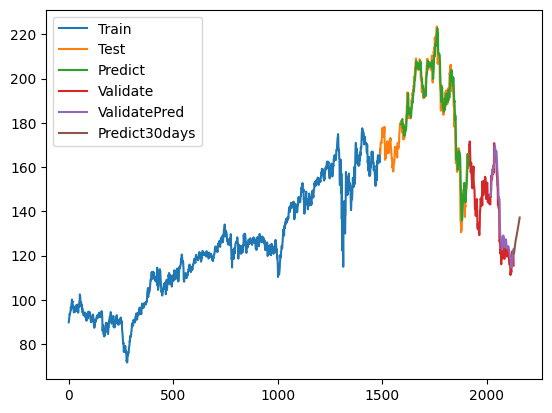

In [83]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
predict_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(predict_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

### 2. Bộ dữ liệu ARI Historical Data

In [84]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ARI-Historical-Data.csv')
df1=df.reset_index()['Price']

In [85]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [86]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [87]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [88]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [89]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [90]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [91]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 [==============================] - 6s 126ms/step - loss: 0.1245 - val_loss: 0.0096
Epoch 2/100
22/22 [==============================] - 2s 92ms/step - loss: 0.0095 - val_loss: 0.0099
Epoch 3/100
22/22 [==============================] - 2s 84ms/step - loss: 0.0053 - val_loss: 0.0040
Epoch 4/100
22/22 [==============================] - 2s 86ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 5/100
22/22 [==============================] - 2s 87ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 6/100
22/22 [==============================] - 2s 86ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 7/100
22/22 [==============================] - 2s 87ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 8/100
22/22 [==============================] - 2s 87ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 9/100
22/22 [==============================] - 2s 91ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 10/100
22/22 [==============================] - 2s 90ms/step - loss: 0.0025 - val_loss: 0.001

In [92]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

4/4 [==============================] - 0s 18ms/step


In [93]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [94]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [95]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.29807482656831824
Testing RMSE: 0.3352409084276525
Testing MAE: 0.25145745300952305
Validation MAE: 0.23048631279869425
Testing MAPE: 1.8944407238103533
Validation MAPE: 2.1979988587174164


In [96]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=154
i=0
while(i<30):
    
    if(len(temp_input)>154):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.4596976]
155
1 day input [0.46373057 0.46502591 0.45984456 0.50647668 0.51619171 0.50064767
 0.50712435 0.48704663 0.47668394 0.49352332 0.49676166 0.50064767
 0.50129534 0.50518135 0.50259067 0.50453368 0.52590674 0.51813472
 0.50971503 0.47150259 0.45595855 0.47020725 0.48251295 0.47603627
 0.48056995 0.49028497 0.4876943  0.46567358 0.44753886 0.44365285
 0.44041451 0.46502591 0.46178756 0.45725389 0.46373057 0.43134715
 0.42810881 0.42227979 0.43005181 0.44624352 0.44300518 0.4507772
 0.44365285 0.45790155 0.48056995 0.49352332 0.4857513  0.48121762
 0.47215026 0.46955959 0.48316062 0.49481865 0.48963731 0.4876943
 0.48704663 0.50259067 0.49352332 0.51360104 0.52137306 0.54404145
 0.54598446 0.52007772 0.52266839 0.50712435 0.45336788 0.48510363
 0.49417098 0.48510363 0.5        0.5        0.50064767 0.47020725
 0.48251295 0.49028497 0.47409326 0.47474093 0.46955959 0.45401554
 0.44365285 0.46049223 0.45725389 0.45272021 0.44106218 0.40803109
 0.37759067 0.37629534 0.38212435 0.

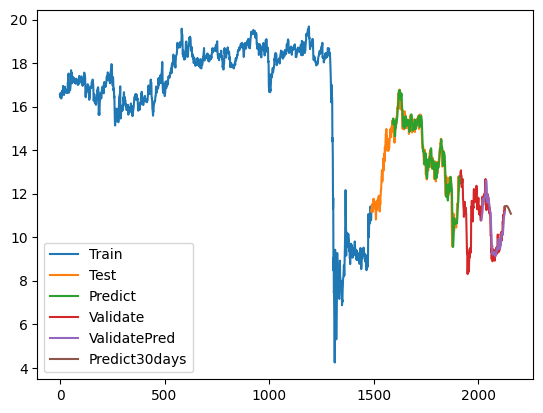

In [97]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

### 3. Bộ dữ liệu MAA Historical Data

In [98]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('MAA-Historical-Data.csv')
df1=df.reset_index()['Price']

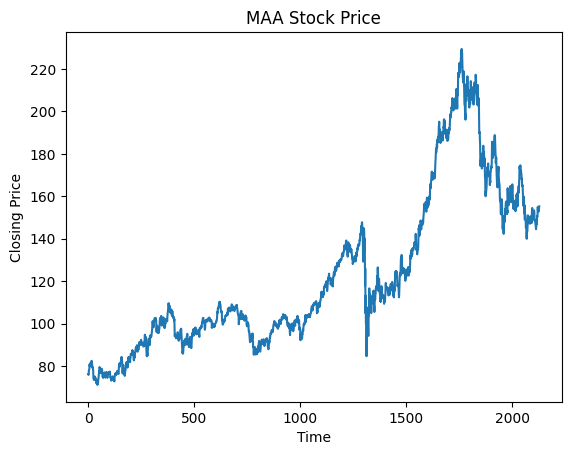

In [99]:
#Vẽ biểu đồ chuỗi thời gian của giá đóng cửa để kiểm tra xu hướng và dao động của dữ liệu:
import matplotlib.pyplot as plt
plt.plot(df1)
plt.title('MAA Stock Price')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

In [100]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [101]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [102]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [103]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [104]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [105]:
# 8. Define LSTM Model
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [106]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
22/22 [==============================] - 6s 126ms/step - loss: 0.0095 - val_loss: 0.0395
Epoch 2/100
22/22 [==============================] - 2s 91ms/step - loss: 0.0016 - val_loss: 0.0052
Epoch 3/100
22/22 [==============================] - 2s 90ms/step - loss: 9.2722e-04 - val_loss: 0.0033
Epoch 4/100
22/22 [==============================] - 2s 90ms/step - loss: 8.8741e-04 - val_loss: 0.0065
Epoch 5/100
22/22 [==============================] - 2s 90ms/step - loss: 8.4216e-04 - val_loss: 0.0060
Epoch 6/100
22/22 [==============================] - 2s 89ms/step - loss: 8.2238e-04 - val_loss: 0.0042
Epoch 7/100
22/22 [==============================] - 2s 89ms/step - loss: 7.8685e-04 - val_loss: 0.0023
Epoch 8/100
22/22 [==============================] - 2s 92ms/step - loss: 8.3582e-04 - val_loss: 0.0122
Epoch 9/100
22/22 [==============================] - 2s 92ms/step - loss: 7.5288e-04 - val_loss: 0.0080
Epoch 10/100
22/22 [==============================] - 2s 90ms/step - lo

In [107]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

4/4 [==============================] - 0s 25ms/step


In [108]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [109]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [110]:
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mape = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 9.856698019052605
Testing RMSE: 10.907469346077358
Testing MAE: 9.532459358874661
Validation MAE: 7.630240543331722
Testing MAPE: 4.920284675184417
Validation MAPE: 5.0070582181238406


In [111]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=154
i=0
while(i<30):
    
    if(len(temp_input)>154):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.502576]
155
1 day input [0.50824436 0.51974225 0.51241392 0.58550761 0.56308042 0.53566239
 0.54014783 0.54223261 0.53503064 0.55316192 0.56074294 0.56687093
 0.56965064 0.57053509 0.54949776 0.57344115 0.59214101 0.58797144
 0.58822415 0.55752101 0.54355929 0.55644703 0.5819698  0.57167225
 0.58418093 0.59687915 0.58948765 0.56870301 0.54614947 0.53168236
 0.52410133 0.53578874 0.5292817  0.53825257 0.54122181 0.52271148
 0.54703393 0.54229579 0.53237728 0.54703393 0.51715206 0.55063491
 0.53452524 0.52795502 0.56510203 0.5644071  0.56074294 0.56996652
 0.54678122 0.53136648 0.53262998 0.54374882 0.56914524 0.57691579
 0.57742119 0.59258323 0.57236717 0.60376524 0.61463137 0.6504517
 0.64375513 0.64167035 0.64615579 0.65361046 0.63421568 0.6331417
 0.63844842 0.62998294 0.62650831 0.61185166 0.61399962 0.59245688
 0.59157243 0.59523659 0.58607619 0.57059827 0.56194327 0.53338809
 0.54147451 0.55796323 0.56011119 0.51020279 0.53553604 0.51652031
 0.49213469 0.50761261 0.50698086 0.5

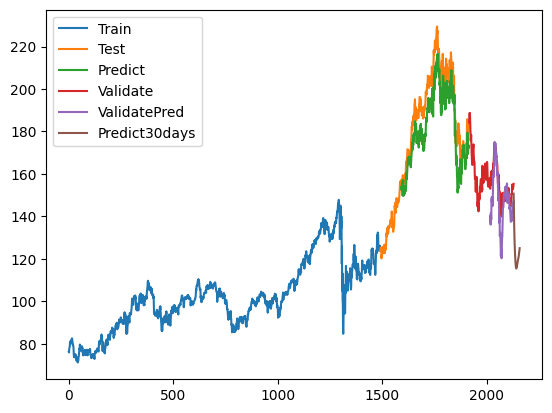

In [112]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()